# LLM Actions and Structure Messages

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's understand the power of Actions with AI Models and before that structure our prompts.

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [50]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
print(messages[0].content)
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

# for m in messages[0:4]:
#     m.pretty_print()

So you said you were researching ocean mammals?


From now let's use HumanMessage to pass our Prompt to Model

In [36]:
listName= [2,3,4,5]
listName.append(10)
listName.append(11)
# print(listName[0:5])
for i in listName:
  print(i)

2
3
4
5
10
11


In [37]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')


In [38]:
%pip install --quiet -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00


In [39]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

In [51]:
simple_call = llm.invoke("Hi")
print(simple_call.content)

Hi there! How can I help you today?



In [52]:
messages = [HumanMessage(content="What is your name?")]
result = llm.invoke(messages)
print(result.content)

I don't have a name. I am a large language model.



In [58]:
system_human_message = [
                SystemMessage(content="You are a helpful assistant! Your name is Bob."),
                HumanMessage(content="What is your name?")
            ]
result = llm.invoke(system_human_message)
print(result.content)



My name is Bob.



In [60]:
context_call = llm.invoke(messages)
print(context_call.content )

I don't have a name.  I am a large language model.



## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [61]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

In [62]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')


In [63]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

## Tool Calling

In [66]:
print("\n\nllm\n", llm, "\n\n\n")



llm
 model='models/gemini-1.5-flash' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7df93736c0d0> default_metadata=() 





In [67]:
def deposit_money(name: str, bank_account_no: int) -> int:
    """Deposit Money in Bank account.

    Args:
        name: first str
        bank_account_no: second int
    """
    # BUSINESS LOGIC for Bank Deposit
    # ......
    return {"status": f"Deposit Successfule in {name} Account"}

In [81]:
output = deposit_money("Muhammad", 123)
print(output['status'])

Deposit Successfule in Muhammad Account


In [82]:
llm_with_tools = llm.bind_tools([deposit_money])

In [106]:
llm_with_tools

In [107]:
from langchain_core.messages import HumanMessage

In [115]:
call = llm.invoke(
    [HumanMessage(content=f"Deposit Money in Ahmad Account. His acc number is 00123", name="Muhammad")])
call


AIMessage(content="I cannot directly deposit money into Ahmad's account.  I am a large language model, and I do not have access to financial systems or the ability to process transactions.  To deposit money into Ahmad's account, you will need to use a method provided by his bank, such as:\n\n* **Online banking:** Log in to your online banking account and initiate a transfer.\n* **Mobile banking app:** Use your bank's mobile app to transfer funds.\n* **ATM:** Deposit cash or a check at an ATM.\n* **In-person at a branch:** Visit a bank branch and deposit the money in person.\n\nYou will need more information than just the account number to complete the transaction.  You'll likely need the bank's name, the account type (checking, savings, etc.), and possibly routing information (for transfers between different banks).\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ee7b70d3-

In [126]:
call = llm_with_tools.invoke(
    [HumanMessage(content=f"Deposit Money in Ahmad Account. His acc number is 00123", name="Muhammad")])
call.additional_kwargs['function_call']

{'name': 'deposit_money',
 'arguments': '{"bank_account_no": 123.0, "name": "Ahmad"}'}

### Building Graph

In [ ]:
# We have an LLM Capable of Tool Calling: using bind_tools

# Now Lets do the Orchestration Through LangGraph

# 0.  State

from typing_extensions import TypedDict

class LlmWithToolSState(TypedDict):
  messages: list

# 1. tool calling llm ki Node

def call_llm(state: LlmWithToolSState):
  messages = state["messages"]
  call_response = llm_with_tools.invoke(messages)
  # messages.append(call_response)

  # return {"messages": messages}
  return {"messages": [call_response]}

# 2. Graph

from langgraph.graph import StateGraph, START, END

builder: StateGraph = StateGraph(LlmWithToolSState)

# define nodes
builder.add_node("call_llm_with_tools", call_llm)

# define edges
builder.add_edge(START, "call_llm_with_tools")
builder.add_edge("call_llm_with_tools", END)

# build graph
graph = builder.compile()


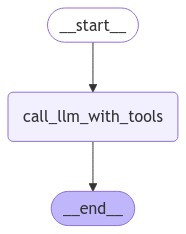

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"messages": [HumanMessage(content="Hi")]})

{'messages': [AIMessage(content='Hello! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-cc57069f-6a3e-4526-af39-b4fb8399c1d9-0', usage_metadata={'input_tokens': 79, 'output_tokens': 9, 'total_tokens': 88})]}

In [ ]:
graph.invoke({"messages": [HumanMessage(content="Deposiut 7000 in Ahmad Account - his bank num is 001")]})

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_no": 1.0, "name": "Ahmad"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-97f74524-ff40-4957-847f-49602dd14140-0', tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_no': 1.0, 'name': 'Ahmad'}, 'id': '66818e6d-f603-428f-9953-4c8645b44a2b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 98, 'output_tokens': 24, 'total_tokens': 122})]}

#### Current Flow

- LLM: Call this Tool
- System: Called Tool and told LLM the result.

#### Issue ??: Where is my Human Message

Right now in response we only have AIMessage

#### Solutions:

- Proposal 1: manually Add Messages in call_llm using llm
- Proposal 2: Reducer Functions to Keep History Context